In [1]:
import load
import oed
import figure

In [2]:
# jsonファイルの読み込み
result = load.load_result_json("../result/Result.json")

gene = result[0]["gene"]

N, M, theta, w_on, w_off, w, g, w_osc, w_nmj = oed.weight(gene)
alpha, x_peak, y_peak, dt, T, f, v, time, tau = oed.constant("setting")
N_, M_, f_inv, T_ = oed.time_constant_step(gene, "setting")

# figure.trajectory(gene, 10)
# figure.newron_output(gene)

# figure.Bearing_vs_Turing_bias("../output/b_vs_t.txt", "../figure/Bearing_vs_Turing_bias.png")
# figure.Normal_gradient_vs_Turing_bias("../output/n_vs_t.txt", "../figure/Normal_gradient_vs_Turing_bias")
# figure.Translational_gradient_vs_Turing_bias("../output/t_vs_t.txt", "../figure/Translational_gradient_vs_Turing_bias")

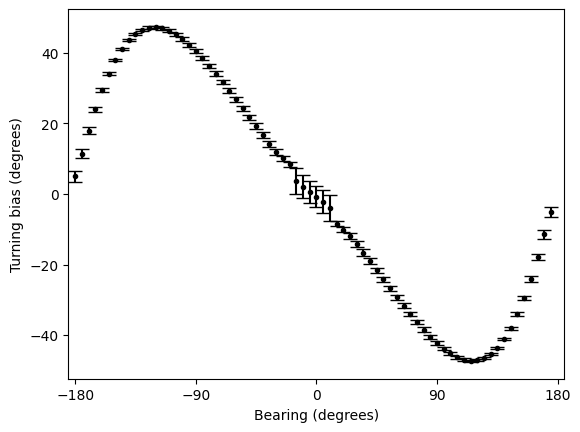

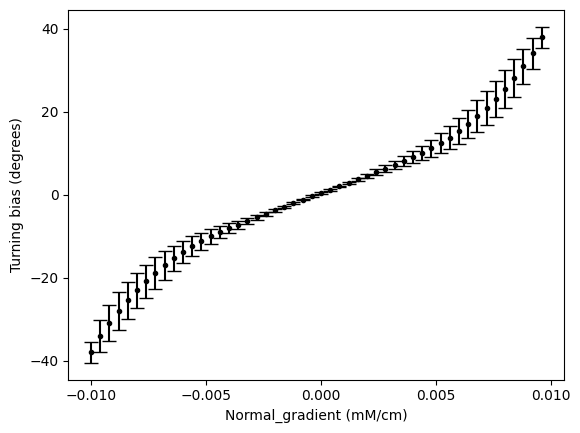

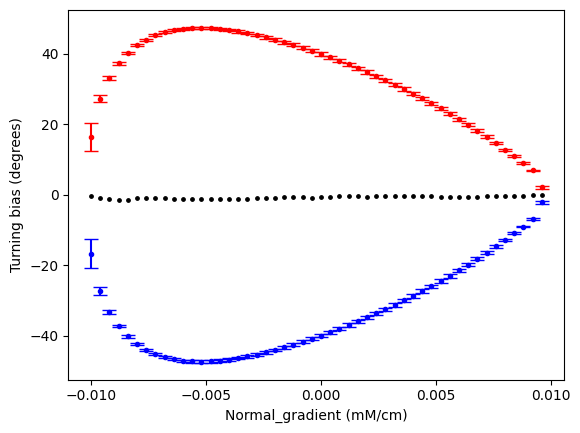

In [3]:
figure.Bearing_vs_Turing_bias(
    "../output/b_vs_t.txt", "../figure/Bearing_vs_Turing_bias.png"
)
figure.Normal_gradient_vs_Turing_bias(
    "../output/n_vs_t.txt", "../figure/Normal_gradient_vs_Turing_bias"
)

figure.Translational_gradient_vs_Turing_bias(
    "../output/t_vs_t.txt", "../figure/Translational_gradient_vs_Turing_bias"
)